# Conic Formulation of Unbalanced OT and Unbalanced GW

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

In [4]:
def distmat(x,y):
    return np.sqrt( np.abs(np.sum(x**2,0)[:,None] + np.sum(y**2,0)[None,:] - 2*x.transpose().dot(y) ) )

# Unbalanced Wasserstein

In [14]:
n = 10
m = 11
k = 25 # angle samples
l = 26 

In [15]:
normalize = lambda a: a/np.sum(a)
# random histograms
a = normalize(np.random.rand(n))
b = normalize(np.random.rand(m))
# 1D histograms
def Gauss(x,m,s): return normalize( np.exp( -(x-m)**2 / (2*s**2) ) )
x = np.linspace(0,1,n)
y = np.linspace(0,1,m)
a = Gauss(x,.2,.1)
b = Gauss(y,.8,.1)

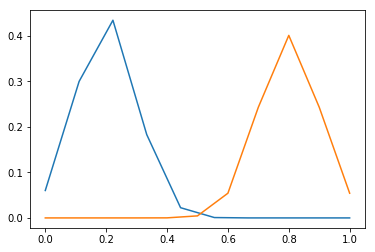

In [16]:
plt.plot(x,a)
plt.plot(y,b)

Discretized radius on the cones. TODO: select wisely `rmax`

In [17]:
rmax = 2
rlist = np.linspace(0,rmax,k)
slist = np.linspace(0,rmax,l)

Define the conic cost for Gaussian-Hellinger with penalty $\tau$ on the marginals
$$
    C(x,r,y,s) \triangleq r^2 + s^2 - 2rs e^{ - d(x,y)^2 /\tau }
$$

In [18]:
tau = 1
D = distmat(x[None,:],y[None,:])
# Wasserstein-Fisher-Rao
def WFR(r,s,d): return r**2+s**2 - 2*r*s*np.cos( np.minimum(d/tau, np.pi/2) )
# Gaussian Hellinger
def GH(r,s,d): return r**2+s**2 - 2*r*s*np.exp( -d**2/tau )
#
C = GH( rlist[None,:,None,None], slist[None,None,None,:], D[:,None,:,None] )
C = np.reshape(C, (n*k,m*l))

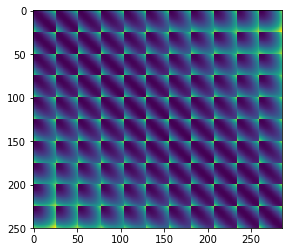

In [19]:
plt.imshow(C)

Conic unbalanced Wasserstein problem
$$
    \min_{\alpha \geq 0} \{ \langle \alpha,C \rangle :
        \sum_{k,j,\ell} \alpha_{i,k,j,l} r_{k}^2 = a_i, 
        \sum_{i,k,\ell} \alpha_{i,k,j,l} s_{\ell}^2 = b_j. 
    \}
$$

In [20]:
Rlist = np.tile(rlist, (n,1))
Slist = np.tile(slist, (m,1))
# variable
alpha = cp.Variable((n*k,m*l))
alpha1 = cp.Variable((n,k))
alpha2 = cp.Variable((m,l))
# constraints
U = [0 <= alpha, 
#        alpha1==cp.reshape(cp.sum(alpha, axis=1),(n,k)), \ # BUG!!
#        alpha2==cp.reshape(cp.sum(alpha, axis=0),(m,l)), \ # BUG!!
        alpha1==cp.reshape(cp.sum(alpha, axis=1),(k,n)).T, \
        alpha2==cp.reshape(cp.sum(alpha, axis=0),(l,m)).T, \
        cp.sum( cp.multiply(alpha1, Rlist**2), 1)==a, \
        cp.sum( cp.multiply(alpha2, Slist**2), 1)==b \
    ]
# solve using CVXPY
objective = cp.Minimize( cp.sum(cp.multiply(alpha,C)) )
prob = cp.Problem(objective, U)
result = prob.solve(verbose=True)


ECOS 2.0.7 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +6.698e-01  +6.698e-01  +3e+05  1e+00  7e-01  1e+00  5e+00    ---    ---    1  2  - |  -  - 
 1  -1.654e+00  -5.036e-01  +1e+05  7e-02  2e-01  1e+00  2e+00  0.7734  2e-01   1  2  2 |  0  0
 2  -1.050e+00  -8.804e-01  +1e+04  7e-03  2e-02  2e-01  2e-01  0.9064  2e-02   1  2  2 |  0  0
 3  -9.577e-01  -9.551e-01  +4e+02  6e-04  4e-04  3e-03  6e-03  0.9732  2e-03   1  2  2 |  0  0
 4  -4.922e-01  -4.922e-01  +4e+01  2e-04  3e-05  3e-05  6e-04  0.9044  2e-03   1  2  2 |  0  0
 5  +3.625e-01  +3.625e-01  +1e+01  4e-05  6e-06  9e-06  1e-04  0.7760  2e-02   1  1  2 |  0  0
 6  +3.846e-01  +3.846e-01  +9e+00  4e-05  5e-06  1e-05  1e-04  0.3255  6e-01   1  2  1 |  0  0
 7  +5.094e-01  +5.094e-01  +4e+00  2e-05  2e-06  5e-06  5e-05  0.6806  1e-01   1  2  2 |  0  0
 8  +5.094e-01  +5.094e-01  +3e+00  2e-05  2e-

Sanity checking that constraint are indeed enforced.

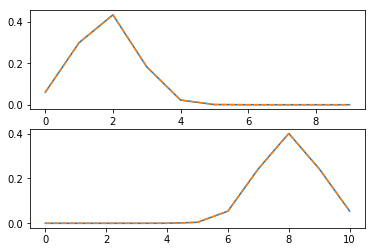

In [21]:
Alpha1 = np.reshape(alpha1.value,(n,k))
Alpha2 = np.reshape(alpha2.value,(m,l))
#
plt.subplot(2,1,1)
plt.plot( np.sum(Alpha1 * rlist[None,:]**2,1) )
plt.plot(a, '--')
plt.subplot(2,1,2)
plt.plot( np.sum(Alpha2 * slist[None,:]**2,1) )
plt.plot(b, '--')

In [22]:
Alpha = np.reshape(alpha.value,(n,k,m,l))
#
B = np.sum(np.sum(Alpha,axis=2,keepdims=True),axis=3,keepdims=True)
B = np.squeeze(B)
print( np.linalg.norm( B - Alpha1 ) )
# 
B = np.sum(np.sum(Alpha,axis=0,keepdims=True),axis=1,keepdims=True)
B = np.squeeze(B)
print( np.linalg.norm( B - Alpha2 ) )

3.429785489871094e-09
1.0324804101111399e-09


# Check bug in reshaping
It appears that there is a bug and that CVXPY is reshaping differently from Numpy!!

` np.reshape(X,(n,p)) == cp.reshape(X,(p,n)).T `

In [23]:
A = np.random.rand(3,4)
# variable
B1 = cp.Variable((3*4))
objective = cp.Minimize( cp.norm(A-cp.reshape(B1,(3,4)) ) )
prob = cp.Problem(objective, U)
result = prob.solve(verbose=False)
B = np.reshape(B1.value,(3,4)) # not working
B = np.reshape(B1.value,(4,3)).T # not working
# 
np.linalg.norm(B-A)

1.1974989921953674e-08